In [1]:
from DFLIMG import DFLJPG
import glob
import numpy as np
import matplotlib.pyplot as plt
import os, sys, math
import csv
import cv2 

In [2]:
def normalize_vector(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def normalize_landmarks(lm):
    c0 = normalize_vector(lm[:,0])
    c1 = normalize_vector(lm[:,1])
    return np.transpose(np.vstack([[c0], [c1]]))

In [3]:
landmarks = []
src_filename = glob.glob('../workspace/data_src/aligned/*.jpg')
for f in src_filename:
    img = DFLJPG.load(f)
    landmarks.append(img.get_landmarks())
np.save("../src_landmarks.npy", landmarks)

In [4]:

print(len(src_filename))
print(len(landmarks))


211
211


In [5]:

norm_landmarks = [normalize_landmarks(lm) for lm in landmarks]
#np.column_stack((NormalizeData(landmarks[0][:,0]), NormalizeData(landmarks[0][:,1])))
print(len(norm_landmarks))



211


In [6]:
all_src_landmarks = norm_landmarks
dst_landmarks = []

dists = []
#dist_imgs = []
for ii, f in enumerate(glob.glob('../workspace/data_dst/aligned/*.jpg')):
    img = DFLJPG.load(f)
    dst_landmarks = normalize_landmarks(img.get_landmarks())
    dists_local = []
    #https://stackoverflow.com/questions/32141856/is-norm-equivalent-to-euclidean-distance
    #https://stackoverflow.com/questions/50849789/what-does-the-numpy-linalg-norm-function
    for f_src, src_landmarks in enumerate(all_src_landmarks):
        dist = np.sum(np.linalg.norm(src_landmarks - dst_landmarks, ord=2, axis=1))
        dists_local.append((dist, f, src_filename[f_src], dst_landmarks, src_landmarks))
    # get the distance between the dst and the best src image
    dists.append((sorted(dists_local, key=lambda d: d[0]))[0])



In [7]:
# sort all samples from the best to the worst landmark pairing
dists = list(sorted(dists, key=lambda d: d[0]))

dist_scores = list(zip(*dists))[0]

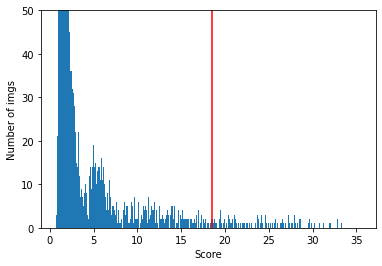

In [8]:
#rangeMin = np.quantile(dist_scores, 0.05)
rangeMax = np.quantile(dist_scores, 0.95)
fig = plt.figure() # Create matplotlib figure
plt.hist(dist_scores, bins=500)
#width = 0.4
plt.xlabel('Score')
plt.ylabel('Number of imgs')
plt.ylim(0, 50)
#plt.axvline(rangeMin, color='red')
plt.axvline(rangeMax, color='red')
plt.show()

In [9]:
print(np.quantile(dist_scores, q=0.95))
#print(np.percentile(dist_scores, q=95))
#np.median(dist_scores)

18.54248433754358


In [10]:
img_index = -200#len(dists)-1
dst_frame_name = dists[img_index][1]
dst_frame_num = str(dists[img_index][1])[-10:-6]
src_frame_name = dists[img_index][2]
print(dst_frame_name, dst_frame_num, src_frame_name)

../workspace/data_dst/aligned/00568_0.jpg 0568 ../workspace/data_src/aligned/26_0.jpg


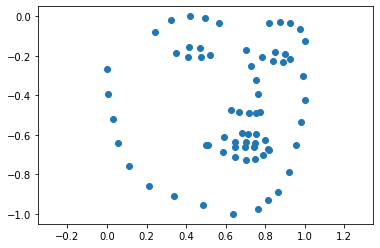

In [11]:
plt.axis('equal')
plt.scatter(list(dists[img_index])[4][:, 0], -list(dists[img_index])[4][:, 1], label='src_img')

(-0.05, 1.05, -1.05, 0.05)

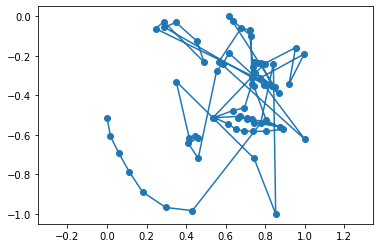

In [12]:
plt.scatter(list(dists[img_index])[3][:, 0], -list(dists[img_index])[3][:, 1])
plt.plot(list(dists[img_index])[3][:, 0], -list(dists[img_index])[3][:, 1])
plt.axis('equal')

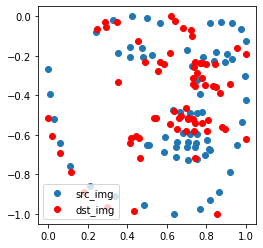

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_aspect('equal')

ax1.scatter(list(dists[img_index])[4][:, 0], -list(dists[img_index])[4][:, 1], label='src_img')
ax1.scatter(list(dists[img_index])[3][:, 0], -list(dists[img_index])[3][:, 1], c='r', label='dst_img')
plt.legend(loc='lower left');
#plt.show()

16.682844123829913 16.682844123829913 16.682844123829913


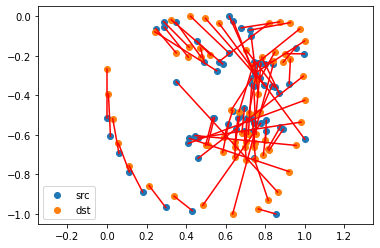

In [14]:
def point_dist(p1, p2):
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    return math.sqrt(dx*dx + dy*dy)
src_lm = dists[img_index][3]
dst_lm = dists[img_index][4]
plt.axis('equal')
plt.scatter(src_lm[:,0], -src_lm[:,1], label='src')
plt.scatter(dst_lm[:,0], -dst_lm[:,1], label='dst')
sum_dd = 0
for x1, y1, x2, y2 in zip(src_lm[:,0], -src_lm[:,1], dst_lm[:,0], -dst_lm[:,1]):
    plt.plot([x1, x2], [y1, y2], c='r')
    dd = point_dist([x1, y1], [x2, y2])
    sum_dd += dd
plt.legend(loc='lower left');
print(sum_dd, dists[img_index][0], np.sum(np.linalg.norm(src_lm - dst_lm, ord=2, axis=1)))

In [15]:
def get_frame(fname, frame_number):
    cmd = f"ffmpeg -i {fname} -vf select='eq(n\,{frame_number})' -vsync 0 frame_{frame_number}.jpg"
    os.system(cmd)
    
video_fname = '../workspace/result.mp4'
get_frame(video_fname, dst_frame_num)

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [16]:
cmd = 'xdg-open '+dst_frame_name+'&'
os.system(cmd)
cmd = 'xdg-open frame_'+dst_frame_num+'.jpg &'
os.system(cmd)
print(cmd)
debug_name = str(dst_frame_name)[0:-12]+"_debug/"+str(dst_frame_name)[-11:-6]+'.jpg'
print(debug_name)
cmd = 'xdg-open '+debug_name+'&'
os.system(cmd)
cmd = 'xdg-open '+src_frame_name+' &'
os.system(cmd)

xdg-open frame_0568.jpg &
../workspace/data_dst/aligned_debug/00568.jpg


0

In [31]:
dists_w_result = []
for i, d in enumerate(dists):
    dists_w_result.append([int(os.path.basename(dists[i][1]).split('_')[0]), d[0] < rangeMax, d[0], d[1],  d[2], "frame_"+str(dists[i][1])[-10:-6]+".jpg", d[3], d[4]])
print((dists_w_result)[0])

[2895, True, 0.7161437586836934, '../workspace/data_dst/aligned/02895_0.jpg', '../workspace/data_src/aligned/130_0.jpg', 'frame_2895.jpg', array([[8.41408585e-04, 4.17848878e-02],
       [0.00000000e+00, 2.11766953e-01],
       [3.56257858e-02, 3.55856703e-01],
       [6.04149712e-02, 4.86793278e-01],
       [1.07006805e-01, 6.17885116e-01],
       [1.79078210e-01, 7.40441066e-01],
       [2.62180387e-01, 8.36923560e-01],
       [3.67063638e-01, 9.37919832e-01],
       [5.15746356e-01, 1.00000000e+00],
       [6.57787187e-01, 9.35631493e-01],
       [7.49149345e-01, 8.31674075e-01],
       [8.22321054e-01, 7.31945786e-01],
       [8.95557486e-01, 6.19141953e-01],
       [9.39810020e-01, 4.88697044e-01],
       [9.73139655e-01, 3.62533019e-01],
       [9.95589540e-01, 2.31932847e-01],
       [1.00000000e+00, 7.50522025e-02],
       [1.06307173e-01, 2.51012683e-02],
       [1.71801416e-01, 8.13299983e-03],
       [2.55378233e-01, 8.72817525e-03],
       [3.31558054e-01, 3.54226832e-02],


In [51]:
img_index = 555#ordered_by_res_name)-1
dst_frame_name = ordered_by_res_name[img_index][3]
dst_frame_num = str(ordered_by_res_name[img_index][0])
src_frame_name = ordered_by_res_name[img_index][4]
print(dst_frame_name, dst_frame_num, src_frame_name)

cmd = 'xdg-open '+dst_frame_name+'&'
os.system(cmd)
cmd = 'xdg-open res_selected_frames/frame_'+dst_frame_num+'.jpg &'
os.system(cmd)
print(cmd)
debug_name = str(dst_frame_name)[0:-12]+"_debug/"+str(dst_frame_name)[-11:-6]+'.jpg'
print(debug_name)
cmd = 'xdg-open '+debug_name+'&'
os.system(cmd)
cmd = 'xdg-open '+src_frame_name+' &'
os.system(cmd)

../workspace/data_dst/aligned/00556_0.jpg 556 ../workspace/data_src/aligned/23_0.jpg
xdg-open res_selected_frames/frame_556.jpg &
../workspace/data_dst/aligned_debug/00556.jpg


gio: file:///home/npunito/DeepFaceLab_Linux/DeepFaceLab/res_selected_frames/frame_556.jpg: Error when getting information for file “/home/npunito/DeepFaceLab_Linux/DeepFaceLab/res_selected_frames/frame_556.jpg”: No such file or directory


0

In [52]:
headers = ["dst_index", "valid_face" , "landmark_distance_sum", "dst_frame_name", "src_frame_name", "result_frame_name", "landmarks"]
with open('dists.csv', 'w') as v:
    write = csv.writer(v) 
    write.writerow(headers)
    write.writerows(dists_w_result)
v.close()